In [1]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model

from util.visualizer import save_images
from util import html
import torch
import erode

device='cuda:1'


opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.gpu_ids=[0]
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='baseline'
opt.netG='unet_256'
#opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all/'
#opt.dataset_mode='sathei'
opt.name='baselineb'
opt.norm='batch'
opt.input_nc=1

opt.output_nc=3
opt.preprocess="none"
# opt.epoch = '440'
opt.attention = False
opt.useVAE3=False
opt.ngf=60
opt.align_minmax=False
opt.add_real=1

opt.use_bias_anyway= 1


model = create_model(opt)
model.setup(opt)
model.eval()
model.netG.eval()
# model.netS.eval()
G=model.netG
# S=model.netS


----------------- Options ---------------
                 add_real: False                         
             align_minmax: False                         
             aspect_ratio: 1.0                           
                attention: False                         
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: None                          
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 1                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3  

In [236]:
opt.dataroot='/home/host/data/training/height29_30km_pix2pix_sathei_all_med29/'
# opt.dataroot = '/home/host/data/training/includeTaiwan'
opt.dataset_mode='sathei'
opt.phase='val'
val_dataset = create_dataset(opt)
opt.phase='train'
tra_dataset = create_dataset(opt)
def blur(x,k):
    k=1/(k+0.0001)
    kernel_size = min(120,int(21/k))
    if kernel_size%2 ==0:kernel_size+=1
    arr = [
        [[x - kernel_size / 2 + 0.5, y - kernel_size / 2 + 0.5] for x in range(kernel_size)]
        for y in range(kernel_size)
    ]
    arr = torch.tensor(arr,device=x.device)
    kernel = (
        torch.exp(-0.015*k*k * (arr[:, :, 0] ** 2 + arr[:, :, 1] ** 2))
        .unsqueeze(0)
        .unsqueeze(0)
    )
    kernel/=kernel.sum()
    pad=torch.nn.ReplicationPad2d([(kernel_size-1)//2]*4)
    return torch.nn.functional.conv2d(pad(x), kernel)


from tqdm import tqdm
count={'Arge':0,'Cana':0,'Heng':0,'Hima':0,'Peru':0,}
latent_mean={'Arge':0,'Cana':0,'Heng':0,'Hima':0,'Peru':0,}
latents={'Arge':[],'Cana':[],'Heng':[],'Hima':[],'Peru':[],}
for i,data in tqdm(enumerate(tra_dataset)):
    name=data['A_paths'][0].split('/')[-1][:4]
    model.set_input(data)
    code=model.netS(torch.cat([model.real_A,model.real_B,model.real_C],dim=1),0)
    latents[name].append(code[0,:,0,0].detach().cpu())
    count[name]+=1
for name,latent in latents.items():
    latents[name]=torch.stack(latent,dim=1)
all_latent_mean=0
for name,latent in latents.items():
    latent_mean[name]=latents[name].mean(dim=1)
    all_latent_mean+=latent_mean[name]
all_latent_mean/=5

5it [00:00, 48.64it/s]

dataset [SatHeiDataset] was created
dataset [SatHeiDataset] was created


2526it [00:26, 96.18it/s]


In [3]:
import torch
import json
import random
import string
import pathlib
import base64
import re
from io import BytesIO
from PIL import Image
from flask import Flask, request, send_file, redirect, render_template, Response
from flask_socketio import SocketIO
import numpy as np



app = Flask(__name__)

bias_r = 0.4

def delete_img():
    folder = "static/result"
    images = os.listdir(folder)
    if len(images) >= 20:
        for image in images[:10]:
            os.remove(os.path.join(folder, image))

import torchvision
cs=256
cs2=cs**2

transform=torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.to(device)),
    torchvision.transforms.Lambda(lambda x: (x[0]-bias_r+x[1]/cs+x[2]/cs2).unsqueeze(0).unsqueeze(0)),
    
    ]
)

@app.route("/", methods=["GET"])
def index():
    return 'Server avaliable'

def getImage(base64string):
    return transform(Image.open(BytesIO(base64.b64decode(re.sub('^data:image/.+;base64,', '', base64string)))).convert("RGB"))

def tensor2im_24(v, imtype=np.uint8):
#     print(v.shape)
    v = torch.clamp(v.data[0][0]+ bias_r,min=0)
    v=torch.stack([v- ((v * cs) % 1) / cs , ((v * cs) % 1) - (((v * cs2) % 1) / cs), (v * cs2) % 1], dim=0)
    image_numpy = v.cpu().float().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0
    return image_numpy.astype(imtype)

def tensor2im(v, imtype=np.uint8):
    v = v.data[0]
    image_numpy = v.cpu().float().numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0)) * 255.0
    return image_numpy.astype(imtype)



@app.route("/generate", methods=["POST"])
def generate():
    if 'action' in request.json:
        action=request.json['action']
    else:
        action='g'
    
    
    global Xo,X,Y,latent,sat,hei
    delete_img()
    path = "static/result"
    pathlib.Path('static/result').mkdir(parents=True, exist_ok=True)
    
    Xo=X = getImage(request.json['structure'])
    
    if 'g' in action:
        bias=(X.min()+X.max()) / 2
        scale = 0.1
        X = (X-bias) / scale    
#         latent = torch.cat([getImage(request.json['latent'][i])for i in range(8)],dim=1) * 500
#         h, w = latent.shape[2],latent.shape[3]

#         for i in range(8):
#             latent[0,i] += all_latent_mean[i]

        output = G(X)
        sat = torch.tanh(output[:,0:3])
        X = output[:,3:4]* scale + bias

    if 'e' in action:
        X=erode.erode(X)
    
    hei_array = tensor2im_24(X)
    hei_image = Image.fromarray(hei_array,"RGB")
    hei_name = ''.join(random.choice(string.ascii_lowercase) for i in range(6))+'.png'              
    hei_image.save(os.path.join(path, hei_name))

    sat_array = tensor2im(sat/2+0.5)
    sat_image = Image.fromarray(sat_array,"RGB")
    sat_name = ''.join(random.choice(string.ascii_lowercase) for i in range(6))+'.png'              
    sat_image.save(os.path.join(path, sat_name))

    if 'g' in action:
        resp = {
            'hei_path': path+'/'+hei_name,
            'sat_path': path+'/'+sat_name,
        }
    else:
        resp = {
            'hei_path': path+'/'+hei_name,
            'sat_path': '',
        }
    
    
    return Response(json.dumps(resp), mimetype="application/json")


socketio = SocketIO(app, cors_allowed_origins='*')
app.run(debug=False, host='0.0.0.0', port=81)

    

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:81/ (Press CTRL+C to quit)
114.137.190.230 - - [03/Feb/2021 04:49:42] "POST /generate HTTP/1.1" 200 -
114.137.190.230 - - [03/Feb/2021 04:49:42] "GET /static/result/wckvdv.png HTTP/1.1" 200 -
114.137.190.230 - - [03/Feb/2021 04:49:43] "GET /static/result/ymfeim.png HTTP/1.1" 200 -
114.137.190.230 - - [03/Feb/2021 04:49:47] "POST /generate HTTP/1.1" 200 -
114.137.190.230 - - [03/Feb/2021 04:49:47] "GET /static/result/swdlvj.png HTTP/1.1" 200 -
114.137.190.230 - - [03/Feb/2021 04:49:48] "GET /static/result/wrcwwt.png HTTP/1.1" 200 -
114.137.190.230 - - [03/Feb/2021 04:49:54] "POST /generate HTTP/1.1" 200 -
114.137.190.230 - - [03/Feb/2021 04:49:54] "GET /static/result/vspofj.png HTTP/1.1" 200 -
114.137.190.230 - - [03/Feb/2021 04:49:56] "GET /static/result/xxcwdr.png HTTP/1.1" 200 -
114.137.190.230 - - [03/Feb/2021 04:50:01] "POST /generate HTTP/1.1" 200 -
114.137.190.230 - - [03/Feb/2021 04:50:01] "GET /static/result/inphut.png HTTP/1.1" 200 -
114.137.190.23

TypeError: Invalid shape (1, 256, 256) for image data

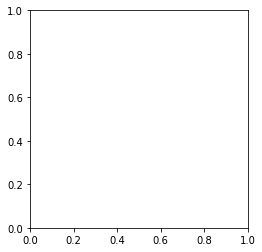

In [81]:
plt.imshow(Xo.detach().cpu()[0], cmap="gray")
plt.colorbar()

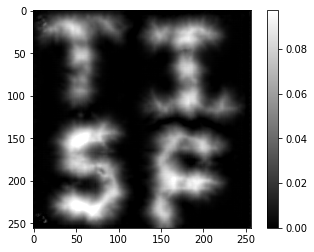

In [98]:
plt.imshow(X.detach().cpu()[0,0],vmin=Xo.min(),vmax=Xo.max(), cmap="gray")
plt.colorbar()

In [66]:
import matplotlib.pyplot as plt


def scat(X,label='',dimx=0,dimy=1):    
    plt.xlim(-r,r)
    plt.ylim(-r,r)    
    plt.xlabel('dim'+str(dimx), fontsize=25)
    plt.ylabel('dim'+str(dimy), fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.scatter(X.t().cpu()[:,dimx],X.t().cpu()[:,dimy], alpha=0.4,edgecolors='none',label=label)
    plt.legend(fontsize=25)

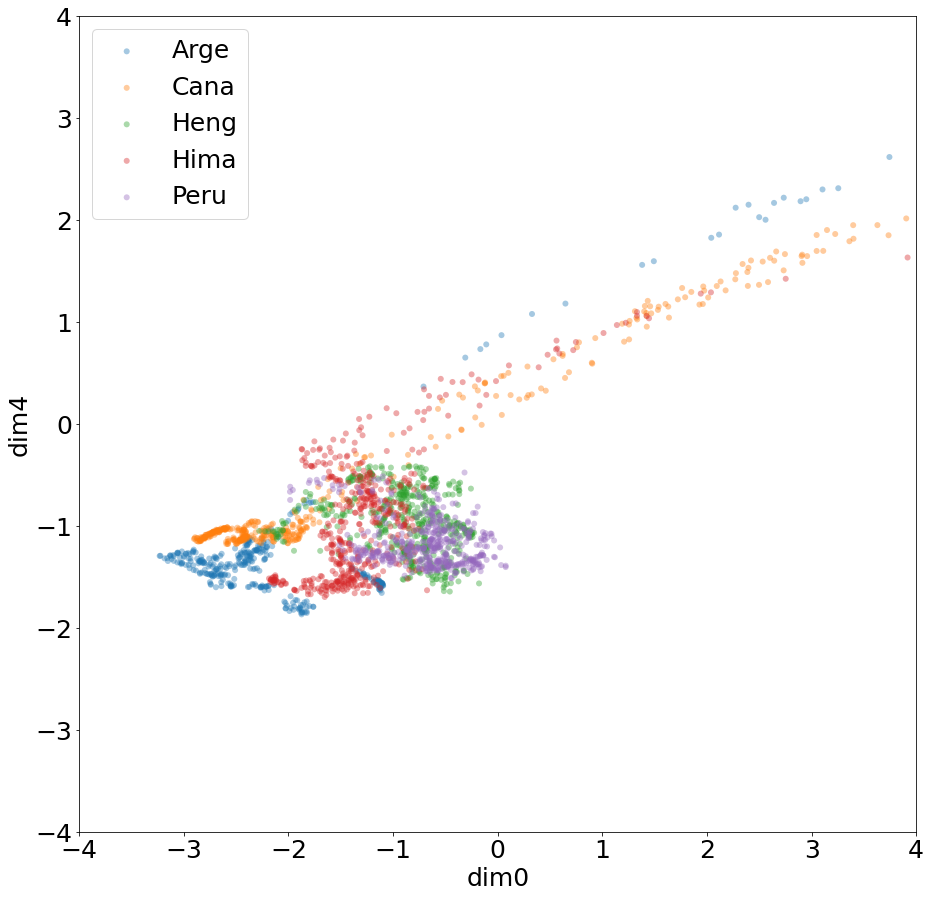

In [73]:
plot_name=['Arge','Cana','Heng','Hima','Peru']
plt.figure(figsize=(15,15))
r=4
# for name,latent in latents.items(): 
#     if name in plot_name:
#         scat(latent,name,0,1)
# plt.figure(figsize=(15,15))
# for name,latent in latents.items(): 
#     if name in plot_name:
#         scat(latent,name,2,3)


# plt.figure(figsize=(15,15))

# for name,latent in latents.items():    
#     if name in plot_name:
#         scat(latent,name,4,5)
        
        
# plt.figure(figsize=(15,15))

# for name,latent in latents.items():    
#     if name in plot_name:
#         scat(latent,name,6,7)  
        
for name, latent in latents.items():
    if name in plot_name:
        scat(latent, name, 0, 4)
        

In [120]:
def p(x):
    plt.imshow(x.detach().cpu(),cmap='gray')
    plt.colorbar()
def pi(x):
    plt.imshow(x.detach().cpu()[0].transpose(0,2).transpose(0,1)/2+0.5)
    plt.colorbar()

In [243]:
for i,data in enumerate(val_dataset):
    if i==0 :
        break

In [244]:
name=data['A_paths'][0].split('/')[-1][:4]
model.set_input(data)
#X=model.real_A
X+=(model.real_A.max()-X.max())
latent=model.netS(torch.cat([model.real_A,model.real_B,model.real_C],dim=1),0)
output = model.netG(torch.cat([X,latent],dim=1)).cpu()
sat=torch.tanh(output[:,0:3])
hei=output[:,3:4]+model.real_A.cpu()

'''
G.eval()
#G.train()
model.test(0)
#model.forward(test=1)
sat=model.fake_B
hei=model.fake_C
'''

/root/anaconda3/envs/scifair/lib/python3.8/site-packages/torch/nn/functional.py:2970: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


'\nG.eval()\n#G.train()\nmodel.test(0)\n#model.forward(test=1)\nsat=model.fake_B\nhei=model.fake_C\n'

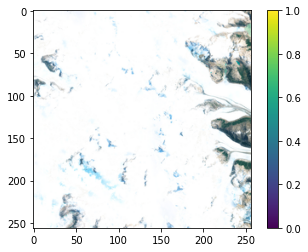

In [245]:
pi(model.real_B)

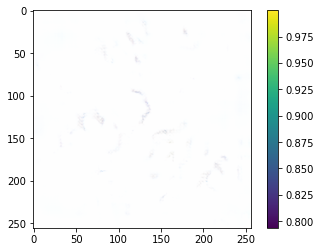

In [246]:
pi(sat)

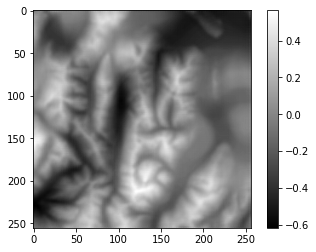

In [207]:
p((hei)[0,0])

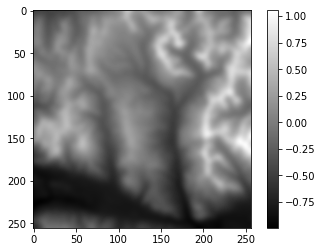

In [127]:
p((blur(model.real_C,0.5))[0,0])

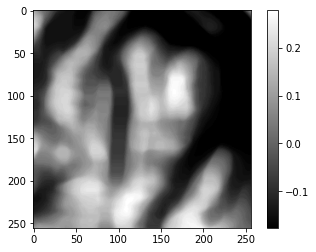

In [209]:
p(X[0,0])

In [249]:
latent[0,:,0,0].cpu()-all_latent_mean

tensor([ 9.9022,  5.5342,  3.8858,  0.6986,  4.8333,  6.7844, -1.8817,  3.2663],
       grad_fn=<SubBackward0>)

In [250]:
latent[0,:,0,0]

tensor([ 9.5881,  5.1060,  4.9211,  1.4978,  4.3201,  4.9150, -1.4449,  2.0579],
       device='cuda:1', grad_fn=<SelectBackward>)

In [18]:
model.netS.module.upsampler(latent[0][0:16].view(1,1,4,4)).shape

NameError: name 'model' is not defined

In [19]:
slider = torch.tensor([[0.]*10]).float()
slider[0,0] = 1
slider[0,1] = -1
latent = torch.mm(U,slider.t())


In [115]:
2.72**np.random.normal(0,0.15)

1.0252944212551023

In [203]:
X.min()


tensor(-0.2902, device='cuda:1')

In [105]:
import erode

In [18]:
import torch
model.set_input(data)
model.forward(torch.tensor([[-0.0010],
        [ 0.5],
        [-0.0356],
        [-0.0015],
        [-0.0081],
        [ 0.0255],
        [0.3],
        [ 0.0295],
        [-0.0169],
        [-0.0107],
        [ 0.1654],
        [0.5],
        [ 0.0121],
        [-0.3842],
        [ 0.0416],
        [ 0.3695]]*16, dtype=torch.float).cuda())

In [22]:
import torchvision
def p(x):
    return torchvision.transforms.ToPILImage()(x[0].detach().cpu()/2+0.5)

In [23]:
p(model.get_current_visuals()['fake_B'])

NameError: name 'model' is not defined

In [95]:
all_latent_mean=0
for name,latent in latents.items():
    latent_mean[name]=latents[name].mean(dim=1)
    all_latent_mean+=latent_mean[name]
all_latent_mean/=5
all_latent_mean

tensor([ 0.9422,  1.0290, -0.1109, -0.6265,  1.2052, -0.5115, -1.0024, -2.2122])

In [25]:
import os
from options.test_options import TestOptions
from data import create_dataset
from models import create_model
from util.visualizer import save_images
from util import html

opt = TestOptions().parse()  # get test options
# hard-code some parameters for test
opt.num_threads = 0   # test code only supports num_threads = 1
opt.batch_size = 1    # test code only supports batch_size = 1
opt.serial_batches = True  # disable data shuffling; comment this line if results on randomly chosen images are needed.
opt.no_flip = True    # no flip; comment this line if results on flipped images are needed.
opt.display_id = -1   # no visdom display; the test code saves the results to a HTML file.
opt.model='vae_pix2pix'
opt.netG='unet_256'
opt.dataroot='/home/host/data/training/height29_10km_pix2pix_sat_all/'
opt.dataset_mode='aligned'
opt.name='1026_vae_sat_all'
opt.norm='batch'
opt.input_nc=1
opt.output_nc=3
opt.preprocess=[]
sat_model = model.create_model(opt)
sat_model.setup(opt)

opt.phase='train'
train_dataset = create_dataset(opt)
opt.phase='val'
val_dataset = create_dataset(opt)
opt.phase='test'
test_dataset = create_dataset(opt)
from tqdm import tqdm
mius_sat=[]
model=sat_model
model.eval()

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: None                          
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0                             	[default: 0]
 

NameError: name 'model' is not defined

In [15]:
torch.nn.Sigmoid()

Sigmoid()

In [17]:
nn=torch.nn
class S(nn.Module):
    def __init__(self):
        super(S,self).__init__()

In [19]:
s=S()

In [22]:
seq=nn.Sequential(s,nn.Conv2d(1,1,1))

In [28]:
list(seq.children())[0].t

123

In [4]:
import torch

x = torch.tensor([
    [[-0.3000, -0.2926],[-0.2705, -0.2632]],
    [[-0.1821, -0.1747],[-0.1526, -0.1453]],
    [[-0.0642, -0.0568],[-0.0347, -0.0274]]
])

x.shape


torch.Size([3, 2, 2])

In [230]:
latent_mean

{'Arge': tensor([ 0.5779,  0.7858,  1.2231,  1.1995,  0.1728, -0.6901,  0.2425, -0.1637]),
 'Cana': tensor([ 0.7513,  0.4675,  1.2677,  0.8720,  0.3863, -1.3654,  0.4463,  0.3256]),
 'Heng': tensor([-0.8955, -1.4667,  0.3164,  0.6384, -0.9619, -2.8675,  0.7188, -1.9814]),
 'Hima': tensor([-1.2086, -0.8699,  0.8290,  0.6814, -0.9130, -2.2315,  0.7798, -1.6909]),
 'Peru': tensor([-0.6987, -1.0357,  1.5411,  0.5574, -1.1777, -2.1231, -0.0400, -2.4641]),
 'Taiw': tensor([-2.0125, -0.8900, -0.4461,  0.9792, -1.2711, -2.7196,  1.1584, -1.3776])}

In [231]:
for n,l in latent_mean.items():
    print(n)
    print(l-all_latent_mean)


Arge
tensor([ 1.2751,  1.3876,  0.2768,  0.2139,  0.9257,  1.7093, -0.4187,  1.3067])
Cana
tensor([ 1.4485,  1.0693,  0.3215, -0.1136,  1.1392,  1.0341, -0.2149,  1.7961])
Heng
tensor([-0.1983, -0.8649, -0.6298, -0.3471, -0.2090, -0.4681,  0.0576, -0.5110])
Hima
tensor([-0.5114, -0.2681, -0.1173, -0.3042, -0.1601,  0.1679,  0.1186, -0.2205])
Peru
tensor([-0.0014, -0.4339,  0.5949, -0.4282, -0.4248,  0.2763, -0.7011, -0.9937])
Taiw
tensor([-1.3153, -0.2882, -1.3923, -0.0063, -0.5181, -0.3201,  0.4973,  0.0928])


In [239]:
t=torch.tensor([-2.0125, -0.8900, -0.4461,  0.9792, -1.2711, -2.7196,  1.1584, -1.3776])

In [240]:
t-all_latent_mean

tensor([-1.6983, -0.4617, -1.4814,  0.1801, -0.7580, -0.8502,  0.7216, -0.1693])

In [5]:
class t:
    def __init__():
        self.beta = 0.005
        self.start_var=50
        a=[]
        for self.epoch in range(1,501):
            a.append(self.netS.loss(self.beta*((0.001+(self.epoch%50)/50.0)if self.epoch>self.start_var else 0.001)))

In [ ]:
self.netS.loss(self.beta*(min(1,(0.001+((self.epoch-1)%100)/50.0))if self.epoch>self.start_var else 0.001))